In [1]:
import mdtraj as md
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd

This notebook compares the two active sites in the crystal structure and the trajectories. 

In [3]:
# Topologies in Amber trajectories
as_d_top = md.load('outputs/trajectories/as_d_top.pdb')
as_h_top = md.load('outputs/trajectories/as_h_top.pdb')
d_top_df, _ = as_d_top.top.to_dataframe()
h_top_df, _ = as_h_top.top.to_dataframe()

# Crystal structure
xtal = md.load('data/MD/2agy_c36_state0.pdb')
xtal = xtal.atom_slice(xtal.top.select('not water'))
xtal_df, _ = xtal.top.to_dataframe()


The differenc between the two numbering schemes. 

In [4]:
d_ix = d_top_df.loc[d_top_df.resName=='TTW', 'resSeq'].unique()[0]
h_ix = h_top_df.loc[h_top_df.resName=='TTW', 'resSeq'].unique()[0]
x_ix = xtal_df.loc[xtal_df.resName=='TTW', 'resSeq'].unique()[0]

## site D vs site H: Crystal Structure

In [4]:
as_res_num = [82, 109, 84, 172, 128, 160]
x_as_d_ix = list(xtal_df.loc[xtal_df.resSeq.isin(as_res_num) & (xtal_df.segmentID=='D'), :].index)
x_as_h_ix = list(xtal_df.loc[xtal_df.resSeq.isin(as_res_num) & (xtal_df.segmentID=='H'), :].index)
x_as_d = xtal.atom_slice(x_as_d_ix)
x_as_h = xtal.atom_slice(x_as_h_ix)

In [5]:
x_heavy_ix = x_as_d.top.select('mass > 1.1')
md.rmsd(target=x_as_d, reference=x_as_h, atom_indices=x_heavy_ix)*10

array([0.06955198], dtype=float32)

## Crystal structure vs MD

In [6]:
heavy_ix = as_d_top.top.select('mass > 1.1')
n_trajs = 100
root_dir = 'outputs/trajectories/'
rmsd_d = [md.rmsd(target=md.load(root_dir+'as_d_{}.xtc'.format(i+1), top=as_d_top), 
                  reference=x_as_d, atom_indices=heavy_ix) for i in range(n_trajs)]
rmsd_h = [md.rmsd(target=md.load(root_dir+'as_h_{}.xtc'.format(i+1), top=as_h_top), 
                  reference=x_as_h, atom_indices=heavy_ix) for i in range(n_trajs)]

For plotting:

In [7]:
to_ns = 0.001
to_ang = 10

In [8]:
traj = md.load(root_dir+'as_d_1.xtc', top=as_d_top)

ts = traj.timestep*to_ns
t = np.arange(0, 100, ts)

t_array = [np.arange(0, x.shape[0]*ts, ts) for x in rmsd_d]
d_array = [np.repeat('D', x.shape[0]) for x in rmsd_d]
h_array = [np.repeat('H', x.shape[0]) for x in rmsd_d]
idx_array = [np.repeat(i+1, x.shape[0]) for i, x in enumerate(rmsd_d)]

In [9]:
rmsd = pd.concat([pd.DataFrame({'t (ns)': np.concatenate(t_array),  
                                'Site': np.concatenate(d_array),
                                'RMSD': np.concatenate(rmsd_d)*to_ang, 
                               'Trajectory': np.concatenate(idx_array)}), 
                   pd.DataFrame({'t (ns)': np.concatenate(t_array),  
                                'Site': np.concatenate(h_array),
                                'RMSD': np.concatenate(rmsd_h)*to_ang, 
                                'Trajectory': np.concatenate(idx_array)})], 
                  axis=0)

In [10]:
rmsd.to_csv('outputs/rmsd_as_traj_vs_xtal.csv')

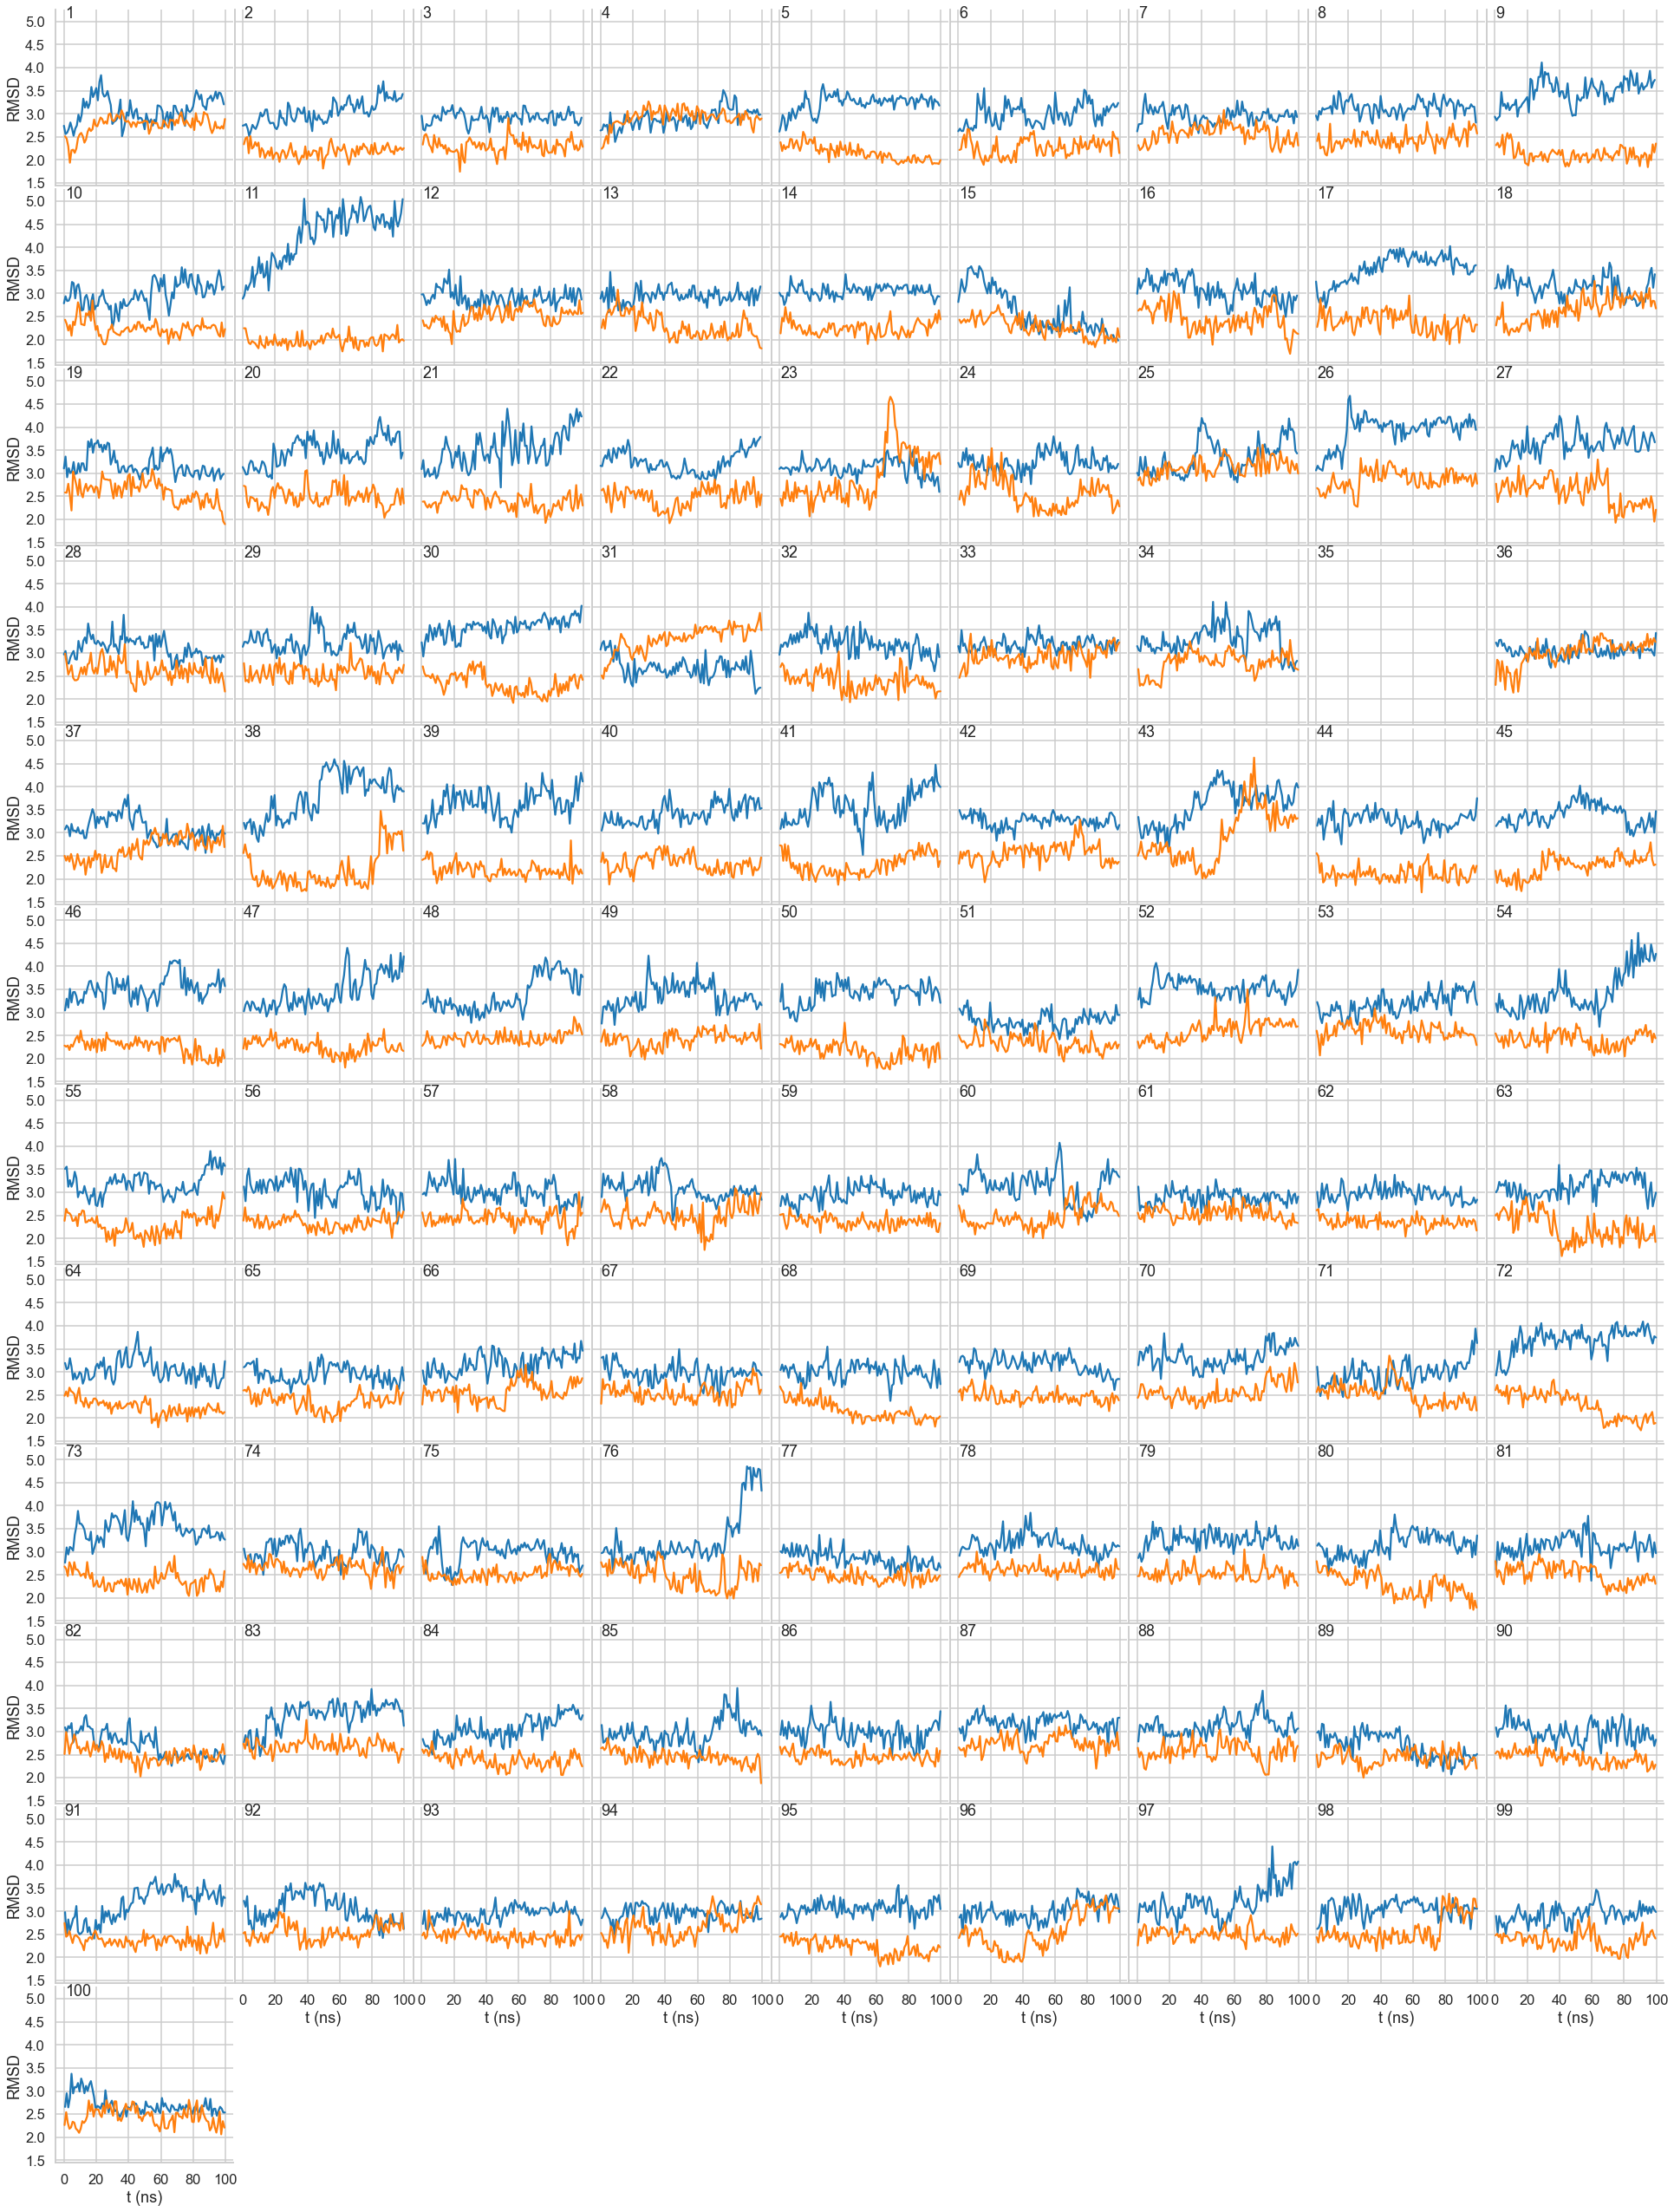

In [28]:
with sns.plotting_context('talk', font_scale=1):
    sns.set_style('whitegrid')
    g = sns.FacetGrid(data= rmsd[::100], hue='Site', col='Trajectory', col_wrap=9)
    g.map(plt.plot, 't (ns)', 'RMSD')
    g.set_titles("")
    g.fig.subplots_adjust(hspace=0.02, wspace=0.01)
    for i, ax in enumerate(g.axes.flatten()):
        ax.annotate(str(i+1), xy=(0.05, 0.95), 
                    xycoords='axes fraction')
    plt.savefig('outputs/rmsd_as_traj_vs_xtal.png', dpi=450, bbox_inches='tight')
    

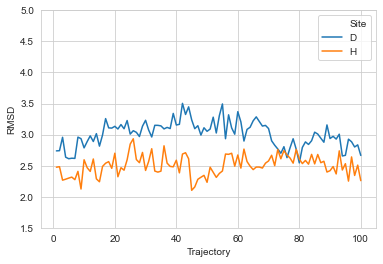

In [12]:

with sns.plotting_context(font_scale=1.25):
    sns.set_style('whitegrid')
    ax = sns.lineplot(data=rmsd.loc[rmsd['t (ns)']==0, :], x='Trajectory', y='RMSD', hue='Site')
    ax.set_ylim(1.5, 5)
    plt.savefig('outputs/rmsd_as_traj_vs_xtal_0ps.png', dpi=450, bbox_inches='tight')

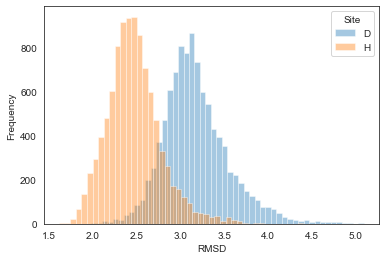

In [13]:

with sns.plotting_context(font_scale=1.25):
    sns.set_style('white')
    ax = sns.distplot(rmsd.query('Site=="D"')[::100]['RMSD'], label='D', kde=False)
    ax = sns.distplot(rmsd.query('Site=="H"')[::100]['RMSD'], label='H', ax=ax, kde=False)
    ax.legend(title='Site')
    ax.set_ylabel('Frequency')
    
#     ax.set_ylim(1.5, 5)
    plt.savefig('outputs/rmsd_as_traj_vs_xtal_dist.png', dpi=450, bbox_inches='tight')